# Text Clustering with Sentence-BERT  
For clustering algorithms, we will need a model that's suitable for textual similarity. Let's use the paraphrase-distilroberta-base-v1 model here for a change. We will start by loading the Amazon Polarity dataset for our clustering experiment. This dataset includes Amazon web page reviews spanning a period of 18 years up to March 2013. The original dataset includes over 35 million reviews. These reviews include product information, user information, user ratings, and user reviews. Let's get started:

In [ ]:
# !pip3 install sentence-transformers

In [ ]:
# !pip install datasets

In [2]:
import pandas as pd, numpy as np
import torch, os
from datasets import load_dataset

In [3]:
dataset = load_dataset("amazon_polarity",split="train")

Reusing dataset amazon_polarity (/home/guy/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc)


In [3]:
dataset

Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 3600000
})

In [4]:
dataset[0]

{'label': 1,
 'title': 'Stuning even for the non-gamer',
 'content': 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'}

randomly select 10K reviews by shuffling, as follows:

In [4]:
corpus=dataset.shuffle(seed=42)[:10000]['content']

Loading cached shuffled indices for dataset at /home/guy/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc/cache-136155fe6e7a2382.arrow


In [5]:
len(corpus)

10000

<AxesSubplot:>

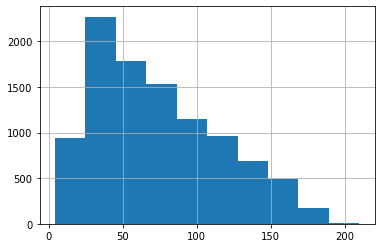

In [9]:
pd.Series([len(e.split()) for e in corpus]).hist()

## Model Selection
(source link: https://www.sbert.net/docs/pretrained_models.html)
The best available models for STS are:

* stsb-mpnet-base-v2
* stsb-roberta-base-v2
* stsb-distilroberta-base-v2
* nli-mpnet-base-v2
* nli-roberta-base-v2 
* nli-distilroberta-base-v2

Paraphrase Identification Models
* paraphrase-distilroberta-base-v1 - Trained on large scale paraphrase data.
* paraphrase-xlm-r-multilingual-v1 - Multilingual version of paraphrase-distilroberta-base-v1, trained on parallel data for 50+ languages. (Teacher: paraphrase-distilroberta-base-v1, Student: xlm-r-base)

The following code instantiates a sentencetransformer object using the pre-trained `paraphrase-distilroberta-base-v1` model:

In [10]:
from sentence_transformers import SentenceTransformer
model_path="paraphrase-distilroberta-base-v1"
#paraphrase-distilroberta-base-v1 - Trained on large scale paraphrase data.
model = SentenceTransformer(model_path)

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

The entire corpus is encoded with the following execution, where the model maps a list of sentences to a list of embedding vectors:

In [11]:
corpus_embeddings = model.encode(corpus)
corpus_embeddings.shape

(10000, 768)

Here, the vector size is 768, which is the default embedding size of the BERT-base model.

From now on, we will proceed with traditional clustering methods. We will choose Kmeans here since it is a fast and widely used clustering algorithm. We just need to set the cluster number (K) to 5. Actually, this number may not be optimal. There are many techniques that can determine the optimal number of clusters, such as the Elbow or Silhouette method. However, let's leave these issues aside. Here is the execution

In [12]:
from sklearn.cluster import KMeans
K=5
kmeans = KMeans(n_clusters=5, random_state=0).fit(corpus_embeddings)

In [13]:
import pandas as pd
cls_dist=pd.Series(kmeans.labels_).value_counts()
cls_dist

0    2759
3    2155
4    1893
1    1847
2    1346
dtype: int64

Here, we have obtained five clusters of reviews. As we can see from the output, we have fairly distributed clusters. Another issue with clustering is that we need to understand what these clusters mean. As a suggestion, we can apply topic analysis to each cluster or check cluster-based TF-IDF to understand the content. Now, let's look at another way to do this based on the cluster centers. The Kmeans algorithm computes cluster centers, called centroids, that are kept in the kmeans.cluster_ centers_ attribute. The centroids are simply the average of the vectors in each cluster. Therefore, they are all imaginary points, not the existing data points. Let's assume that the sentences closest to the centroid will be the most representative example for the corresponding cluster.  

Let's try to find only one real sentence embedding, closest to each centroid point. 

In [14]:
import scipy
distances = scipy.spatial.distance.cdist(kmeans.cluster_centers_ , corpus_embeddings)

In [15]:
centers={}
print("Cluster", "Size", "Center-idx", "Center-Example", sep="\t\t")
for i,d in enumerate(distances):
  ind = np.argsort(d, axis=0)[0]
  centers[i]=ind
  print(i,cls_dist[i], ind, corpus[ind] ,sep="\t\t")

Cluster		Size		Center-idx		Center-Example
0		2759		1761		I read this book a while back and thought it was very interesting. It's a good book to read if your tired of just reading love stories all the time.
1		1847		9447		I ordered the product I see on the screen but what I got was a white bottle of some other type of shampoo... it was NOT just the packaging.How can someone be loyal to a product if they keep changing the formulas!? You will never keep everyone happy.I was disappointed that after 2 calls no correction was ever sent. VERY disappointed.
2		1346		3900		This album like many rock/emo albums is good, but there is nothing innovative about it, some very catchy tunes, good singing, nice rhythm. Awesome to listen to. Worth the buy.
3		2155		1474		The quality of this product is great, easy to clean and fits my sink perfectly.However, I think it is a little bit expensive.
4		1893		204		This DVD looks nice and all but is horrible because it skips and stuff after the first time I watc

## Visualization of the cluster points

In [ ]:
# !pip install umap-learn

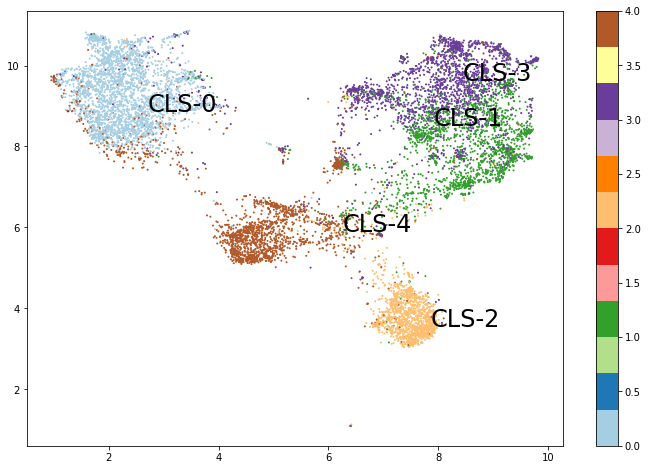

In [16]:
import matplotlib.pyplot as plt
import umap
X = umap.UMAP(n_components=2, min_dist=0.0).fit_transform(corpus_embeddings)
labels= kmeans.labels_

fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(X[:,0], X[:,1], c=labels, s=1, cmap='Paired')
for c in centers:
  plt.text(X[centers[c],0], X[centers[c], 1], "CLS-"+ str(c), fontsize=24) 
plt.colorbar()

## Topic Modeling with BERT

BERTopic Official NOTE: BERTopic is stocastich which means that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.  

You may be familiar with many unsupervised topic modeling techniques that are used to extract topics from documents; Latent-Dirichlet Allocation (LDA) topic modeling and Non-Negative Matrix Factorization (NMF) are well-applied traditional techniques in the literature. BERTopic and Top2Vec are two important transformer-based topic modeling projects. In this section, we will apply the BERTopic model to our Amazon corpus. It leverages BERT embeddings and the class-based TF-IDF method to get easily interpretable topics.

First, the BERTopic model starts by encoding the sentences with sentence transformers or any sentence embedding model, which is followed by the clustering step. The clustering step has two phases: the embedding's dimensionality is reduced by UMAP and then the reduced vectors are clustered by Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN), which yields groups of similar documents. At the final stage, the topics are captured by cluster-wise TF-IDF, where the model extracts the most important words per cluster rather than per document and obtains descriptions of the topics for each cluster.

In [ ]:
# !pip install bertopic

Official Note: Restart the Notebook
After installing BERTopic, some packages that were already loaded were updated and in order to correctly use them, we should now restart the notebook.

From the Menu:

Runtime → Restart Runtime

In [6]:
len(corpus)

10000

In [7]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
sentence_model = SentenceTransformer("paraphrase-distilroberta-base-v1")
topic_model = BERTopic(embedding_model=sentence_model)
topics, _ = topic_model.fit_transform(corpus)

In [8]:
topic_model.get_topic_info()[:6]

,Topic,Count,Name
0,-1,1,-1_puppy_video_partner_hunting
1,0,5238,0_the_it_and_to
2,1,3110,1_the_book_of_and
3,2,1312,2_the_and_of_is
4,3,231,3_game_the_you_it
5,4,90,4_the_and_this_it


In [9]:
topic_model.get_topic(2)

[('the', 0.0663253122056153),
 ('and', 0.051876598571362814),
 ('of', 0.04820171400544162),
 ('is', 0.04769234548620355),
 ('this', 0.04602651326096612),
 ('to', 0.042680616658177316),
 ('cd', 0.04095042335782136),
 ('album', 0.03970878356380576),
 ('it', 0.035688744081066495),
 ('you', 0.032443088975137105)]

The topic words are those words whose vectors are close to the topic vector in the semantic space. In this experiment, we did not cluster the corpus; instead, we applied the technique to the entire corpus. In our previous example, we analyzed the clusters with the closest sentence. Now, we can find the topics by applying the topic model separately to each cluster. This is pretty straightforward, and you can run it yourself  

